TASK1: Generative Model

In [337]:
accuracy_list = []
error_list = []

In [338]:
import numpy as np
import os
import random

def read_input_file(feature_file, label_file):
    input_feature = np.loadtxt(open("/Users/sahiltyagi/Downloads/pp3data/" + feature_file, "rb"), delimiter=",")
    input_label = np.loadtxt(open("/Users/sahiltyagi/Downloads/pp3data/" + label_file, "rb"), delimiter=",")
    #print(input_label.shape)
    #print(input_feature.shape)
    
    test_set_size = int(input_feature.shape[0]/3)
    train_set_size = int(input_feature.shape[0] - test_set_size)
    ctr = 0
    test_set_indices = []
    
    while len(test_set_indices) < test_set_size:
        ix = random.randint(0, input_feature.shape[0]-1)
        if ix not in test_set_indices:
            test_set_indices.append(ix)
    #print('len test_set_indices ' + str(len(test_set_indices)))
        
    all_indices = []
    for i in range(0, input_feature.shape[0]):
        all_indices.append(i)
    #print('len all indices ' + str(len(all_indices)))
        
    train_set_indices = []
    for ix in all_indices:
        if ix not in test_set_indices:
            train_set_indices.append(ix)
    #print('len train_set_indices ' + str(len(train_set_indices)))
        
    testset_features = np.take(input_feature, test_set_indices, axis=0)
    testset_label = np.take(input_label, test_set_indices, axis=0)
    #print('test set..')
    #print(testset_features.shape)
    #print(testset_label.shape)
    
    trainset_features = np.take(input_feature, train_set_indices, axis=0)
    trainset_label = np.take(input_label, train_set_indices, axis=0)
    #print('train set..')
    #print(trainset_features.shape)
    #print(trainset_label.shape)
    
    return trainset_features, trainset_label, testset_features, testset_label, train_set_size

In [339]:
import math

def calculate_a(sampled_trainset_features, sampled_trainset_label, shared_covariance):
    pc_1 = 0
    pc_0 = 0
    
    label_1_indices = []
    label_0_indices = []
    
    for ix in range(0, sampled_trainset_label.shape[0]):
        if sampled_trainset_label[ix] == 1:
            pc_1 = pc_1 + 1
            label_1_indices.append(ix)
        else:
            pc_0 = pc_0 + 1
            label_0_indices.append(ix)
    
    #print(pc_1)
    #print(pc_0)
            
    pc_1 = float(pc_1)/float(sampled_trainset_label.shape[0])
    pc_0 = float(pc_0)/float(sampled_trainset_label.shape[0])
    #print('1 label probability ' + str(pc_1))
    #print('0 label probability ' + str(pc_0))
    
    label_1_features = np.take(sampled_trainset_features, label_1_indices, axis=0)
    label_0_features = np.take(sampled_trainset_features, label_0_indices, axis=0)
    
    mew_1 = np.mean(label_1_features, axis=0)
    #print(mew_1.shape)
    mew_0 = np.mean(label_0_features, axis=0)
    #print(mew_0.shape)
    
    sigma1 = (np.matmul(np.transpose(label_1_features - mew_1), 
                           label_1_features - mew_1))/sampled_trainset_features.shape[0]
    sigma0 = (np.matmul(np.transpose(label_0_features - mew_0), 
                           label_0_features - mew_0))/sampled_trainset_features.shape[0]
    #print(sigma1.shape)
    #print(sigma0.shape)
        
    sigma = sigma1 + sigma0
    sigma_inverse = np.linalg.inv(sigma)
    #print(sigma_inverse.shape)
    
    w = np.matmul(sigma_inverse, mew_1 - mew_0)
    #print(w.shape)
    
    #print('w0 individual values are..')
    #print(math.log(pc_1/pc_0))
    #print(np.multiply(np.matmul(np.transpose(mew_1), np.matmul(sigma_inverse, mew_1)), 0.5))
    #print(np.multiply(np.matmul(np.transpose(mew_0), np.matmul(sigma_inverse, mew_0)), 0.5))
    
    w0 = math.log(pc_1/pc_0) - np.multiply(np.matmul(np.transpose(mew_1), np.matmul(sigma_inverse, mew_1)), 0.5) + np.multiply(np.matmul(np.transpose(mew_0), np.matmul(sigma_inverse, mew_0)), 0.5)
    #print(w0)
    
    if shared_covariance:
        quadratc_term = None
        
    elif not shared_covariance:
        sigma1_inverse = np.linalg.inv(sigma1)
        sigma0_inverse = np.linalg.inv(sigma0)
        quadratc_term = np.multiply(sigma1_inverse - sigma0_inverse, -0.5)
    
    return w0, w, quadratc_term

In [340]:
def calculate_accuracy_and_error(a, testset_label):
    correct = 0
    total = 0
    for ix in range(0, a.shape[0]):
        if a[ix] >= 0:
            y_pred = 1
        else:
            y_pred = 0
        
        if y_pred == testset_label[ix]:
            correct = correct + 1
        
        total = total + 1
    
    accuracy = float(correct)/float(total)
    error = 1 - accuracy
    print('accuracy is ' + str(accuracy))
    print('error is ' + str(1 - accuracy))
    return accuracy, error
        

In [341]:
def calculate_A_in_nonshared_covariances(testset_features, w, w0, quad_term):
    a = []
    for ix in range(0, testset_features.shape[0]):
        record = testset_features[ix,:]
        a.append(w0 + np.matmul(record, w) + np.matmul(record, np.matmul(quad_term, np.transpose(record))))
        
    a = np.array(a)
    print(a)
    return a
    

In [342]:
import math

def loop_training_set_sizes(feature_file, label_file, shared_covariance=True):
    trainset_features, trainset_label, testset_features, testset_label, train_set_size = read_input_file(
    feature_file, label_file)
    
    fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    #fractions = [1.0]
    
    for frac in fractions:
        final_trainset_size = int(frac * train_set_size)
        sampled_trainset_features = trainset_features[0:final_trainset_size,:]
        sampled_trainset_label = trainset_label[0:final_trainset_size,]
        #print(sampled_trainset_features.shape)
        #print(sampled_trainset_label.shape)
        
        if shared_covariance:
            w0, w, _ = calculate_a(sampled_trainset_features, sampled_trainset_label, shared_covariance)
            a = w0 + np.matmul(testset_features, w)
            #print(a)
            acc, err = calculate_accuracy_and_error(a, testset_label)
            accuracy_list.append(acc)
            error_list.append(err)
            
        elif not shared_covariance:
            w0, w, quad_term = calculate_a(sampled_trainset_features, sampled_trainset_label, shared_covariance)
            a = calculate_A_in_nonshared_covariances(testset_features, w, w0, quad_term)
            acc, err = calculate_accuracy_and_error(a, testset_label)
            accuracy_list.append(acc)
            error_list.append(err)
            
        

In [326]:
loop_training_set_sizes('B.csv', 'labels-B.csv', shared_covariance=False)

[ 2.03382145e+18  4.33970759e+17 -2.40680162e+17  1.50134510e+18
 -1.98180954e+18  4.98657233e+16 -5.35384746e+16  1.30143926e+17
  2.43530601e+17  2.72538883e+17 -6.92689421e+17 -3.90266545e+17
  1.37173625e+17  6.78956715e+16  5.07872690e+17 -8.74517192e+16
  4.41946965e+17  2.53564446e+15  3.95475775e+17  1.01940906e+18
  5.35942100e+17 -2.65466729e+18  4.80518994e+17  1.91339996e+17
 -1.33335134e+18 -2.85728577e+18 -8.56322398e+16  3.64237896e+17
  1.13481175e+17  2.22053732e+18  5.37307803e+18 -4.90915583e+17
  7.23297116e+18  2.37286250e+18 -1.02231666e+18  5.28436603e+17
  1.66423283e+17  7.76124034e+17  1.25898816e+17 -1.35410827e+18
  3.97850808e+17 -7.81181558e+17  3.68711277e+17  4.98586341e+17
  1.20550619e+17  2.69461762e+17  8.05278951e+16  6.77940484e+16
  2.09231691e+17  7.64402938e+17 -4.25560054e+16 -3.68489876e+17
 -4.95269170e+15 -1.38704869e+17  1.65490574e+16  9.52804013e+16
 -6.42701928e+17  1.71369197e+17  9.17707533e+17  4.96508283e+18
  7.76411677e+17 -1.47236

accuracy is 0.839339339339
error is 0.160660660661
accuracy is 0.902402402402
error is 0.0975975975976
accuracy is 0.912912912913
error is 0.0870870870871
accuracy is 0.948948948949
error is 0.0510510510511
accuracy is 0.942942942943
error is 0.0570570570571
accuracy is 0.953453453453
error is 0.0465465465465
accuracy is 0.957957957958
error is 0.042042042042
accuracy is 0.95045045045
error is 0.0495495495495
accuracy is 0.95045045045
error is 0.0495495495495
accuracy is 0.954954954955
error is 0.045045045045
accuracy is 0.869369369369
error is 0.130630630631
accuracy is 0.894894894895
error is 0.105105105105
accuracy is 0.92042042042
error is 0.0795795795796
accuracy is 0.942942942943
error is 0.0570570570571
accuracy is 0.930930930931
error is 0.0690690690691
accuracy is 0.941441441441
error is 0.0585585585586
accuracy is 0.941441441441
error is 0.0585585585586
accuracy is 0.95045045045
error is 0.0495495495495
accuracy is 0.932432432432
error is 0.0675675675676
accuracy is 0.9369369

accuracy is 0.873873873874
error is 0.126126126126
accuracy is 0.896396396396
error is 0.103603603604
accuracy is 0.915915915916
error is 0.0840840840841
accuracy is 0.924924924925
error is 0.0750750750751
accuracy is 0.936936936937
error is 0.0630630630631
accuracy is 0.933933933934
error is 0.0660660660661
accuracy is 0.935435435435
error is 0.0645645645646
accuracy is 0.936936936937
error is 0.0630630630631
accuracy is 0.93993993994
error is 0.0600600600601
accuracy is 0.941441441441
error is 0.0585585585586
accuracy is 0.863363363363
error is 0.136636636637
accuracy is 0.887387387387
error is 0.112612612613
accuracy is 0.902402402402
error is 0.0975975975976
accuracy is 0.915915915916
error is 0.0840840840841
accuracy is 0.929429429429
error is 0.0705705705706
accuracy is 0.929429429429
error is 0.0705705705706
accuracy is 0.929429429429
error is 0.0705705705706
accuracy is 0.929429429429
error is 0.0705705705706
accuracy is 0.926426426426
error is 0.0735735735736
accuracy is 0.927

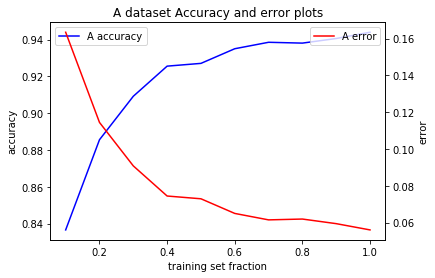

In [559]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

accuracy_plot = []
error_plot = []

accuracy_list = []
error_list = []
repeats = 30
for i in range(0, repeats):
    loop_training_set_sizes('A.csv', 'labels-A.csv')
    
trainset_size_indices = [0,1,2,3,4,5,6,7,8,9]
fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for ix in range(0, len(trainset_size_indices)):
    average_accuracy = 0.0
    average_error = 0.0
    ctr = ix
    while ctr < len(accuracy_list):
        average_accuracy = average_accuracy + accuracy_list[ctr]
        average_error = average_error + error_list[ctr]
        ctr = ctr + len(trainset_size_indices)
        
    print('FOR TRAINING SET FRAC ' + str(trainset_size_indices[ix]))
    print('average accuracy is ' + str(float(average_accuracy)/repeats))
    print('average error is ' + str(float(average_error)/repeats))
    accuracy_plot.append(float(average_accuracy)/repeats)
    error_plot.append(float(average_error)/repeats)

ax1.plot(fractions, accuracy_plot, label='A accuracy', color='b')
ax1.set_xlabel('training set fraction')
ax1.set_ylabel('accuracy')
ax1.legend(loc='best')
ax1.set_title('A dataset Accuracy and error plots')

ax2.plot(fractions, error_plot, label='A error', color='r')
ax2.set_xlabel('training set fraction')
ax2.set_ylabel('error')
ax2.legend(loc='best')
    

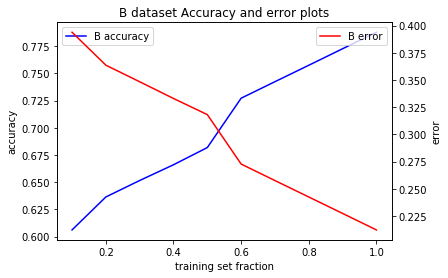

In [643]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

accuracy_plot = []
error_plot = []
# fractions1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

accuracy_list = []
error_list = []
repeats = 30
for i in range(0, repeats):
    loop_training_set_sizes('B.csv', 'labels-B.csv', shared_covariance=False)
    
trainset_size_indices = [0,1,2,3,4,5,6,7,8,9]
fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for ix in range(0, len(trainset_size_indices)):
    average_accuracy = 0.0
    average_error = 0.0
    ctr = ix
    while ctr < len(accuracy_list):
        average_accuracy = average_accuracy + accuracy_list[ctr]
        average_error = average_error + error_list[ctr]
        ctr = ctr + len(trainset_size_indices)
        
    print('FOR TRAINING SET FRAC ' + str(trainset_size_indices[ix]))
    print('average accuracy is ' + str(float(average_accuracy)/repeats))
    print('average error is ' + str(float(average_error)/repeats))
    accuracy_plot.append(float(average_accuracy)/repeats)
    error_plot.append(float(average_error)/repeats)
    
accuracy_plot1 = [0.60606,0.6363636,0.65151,0.666,0.6818,0.7272,0.7424,0.7575,0.7727,0.78787]
error_plot1 = [0.393939,0.36363636,0.3484,0.333,0.31818,0.2727,0.2575,0.2424,0.22727,0.2121]
ax1.plot(fractions, accuracy_plot, label='B accuracy', color='b')
ax1.set_xlabel('training set fraction')
ax1.set_ylabel('accuracy')
ax1.legend(loc='best')
ax1.set_title('B dataset Accuracy and error plots')

ax2.plot(fractions, error_plot, label='B error', color='r')
ax2.set_xlabel('training set fraction')
ax2.set_ylabel('error')
ax2.legend(loc='best')
    

In [636]:
loop_training_set_sizes('usps.csv', 'labels-usps.csv', shared_covariance=True)

accuracy is 0.543859649123
error is 0.456140350877
accuracy is 0.43469785575
error is 0.56530214425
accuracy is 0.826510721248
error is 0.173489278752
accuracy is 0.894736842105
error is 0.105263157895
accuracy is 0.943469785575
error is 0.056530214425
accuracy is 0.937621832359
error is 0.0623781676413
accuracy is 0.947368421053
error is 0.0526315789474
accuracy is 0.955165692008
error is 0.0448343079922
accuracy is 0.955165692008
error is 0.0448343079922
accuracy is 0.95126705653
error is 0.0487329434698


accuracy is 0.522417153996
error is 0.477582846004
accuracy is 0.528265107212
error is 0.471734892788
accuracy is 0.748538011696
error is 0.251461988304
accuracy is 0.881091617934
error is 0.118908382066
accuracy is 0.90253411306
error is 0.0974658869396
accuracy is 0.916179337232
error is 0.083820662768
accuracy is 0.93567251462
error is 0.0643274853801
accuracy is 0.95126705653
error is 0.0487329434698
accuracy is 0.95126705653
error is 0.0487329434698
accuracy is 0.955165692008
error is 0.0448343079922
accuracy is 0.538011695906
error is 0.461988304094
accuracy is 0.538011695906
error is 0.461988304094
accuracy is 0.801169590643
error is 0.198830409357
accuracy is 0.881091617934
error is 0.118908382066
accuracy is 0.916179337232
error is 0.083820662768
accuracy is 0.918128654971
error is 0.0818713450292
accuracy is 0.916179337232
error is 0.083820662768
accuracy is 0.929824561404
error is 0.0701754385965
accuracy is 0.943469785575
error is 0.056530214425
accuracy is 0.949317738791
e

accuracy is 0.475633528265
error is 0.524366471735
accuracy is 0.524366471735
error is 0.475633528265
accuracy is 0.785575048733
error is 0.214424951267
accuracy is 0.881091617934
error is 0.118908382066
accuracy is 0.916179337232
error is 0.083820662768
accuracy is 0.931773879142
error is 0.0682261208577
accuracy is 0.93567251462
error is 0.0643274853801
accuracy is 0.937621832359
error is 0.0623781676413
accuracy is 0.945419103314
error is 0.0545808966862
accuracy is 0.95126705653
error is 0.0487329434698
accuracy is 0.534113060429
error is 0.465886939571
accuracy is 0.469785575049
error is 0.530214424951
accuracy is 0.80701754386
error is 0.19298245614
accuracy is 0.900584795322
error is 0.0994152046784
accuracy is 0.927875243665
error is 0.0721247563353
accuracy is 0.947368421053
error is 0.0526315789474
accuracy is 0.953216374269
error is 0.046783625731
accuracy is 0.957115009747
error is 0.0428849902534
accuracy is 0.957115009747
error is 0.0428849902534
accuracy is 0.96101364522

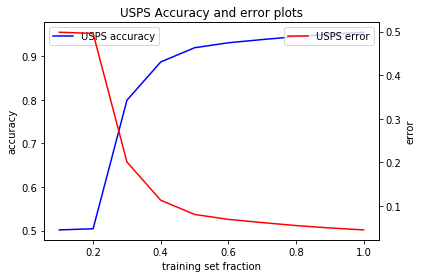

In [566]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

accuracy_plot = []
error_plot = []

accuracy_list = []
error_list = []
repeats = 30
for i in range(0, repeats):
    loop_training_set_sizes('usps.csv', 'labels-usps.csv', shared_covariance=True)
    
trainset_size_indices = [0,1,2,3,4,5,6,7,8,9]
fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for ix in range(0, len(trainset_size_indices)):
    average_accuracy = 0.0
    average_error = 0.0
    ctr = ix
    while ctr < len(accuracy_list):
        average_accuracy = average_accuracy + accuracy_list[ctr]
        average_error = average_error + error_list[ctr]
        ctr = ctr + len(trainset_size_indices)
        
    print('FOR TRAINING SET FRAC ' + str(trainset_size_indices[ix]))
    print('average accuracy is ' + str(float(average_accuracy)/repeats))
    print('average error is ' + str(float(average_error)/repeats))
    accuracy_plot.append(float(average_accuracy)/repeats)
    error_plot.append(float(average_error)/repeats)

ax1.plot(fractions, accuracy_plot, label='USPS accuracy', color='b')
ax1.set_xlabel('training set fraction')
ax1.set_ylabel('accuracy')
ax1.legend(loc='best')
ax1.set_title('USPS Accuracy and error plots')

ax2.plot(fractions, error_plot, label='USPS error', color='r')
ax2.set_xlabel('training set fraction')
ax2.set_ylabel('error')
ax2.legend(loc='best')


DISCRIMINATIVE MODEL

In [679]:
import numpy as np
import os
import random

def read_input_file_with_added_feature(feature_file, label_file):
    input_feature = np.loadtxt(open("/Users/sahiltyagi/Downloads/pp3data/" + feature_file, "rb"), delimiter=",")
    input_label = np.loadtxt(open("/Users/sahiltyagi/Downloads/pp3data/" + label_file, "rb"), delimiter=",")
    print(input_label.shape)
    print(input_feature.shape)
    
    #added a vector column of 1
    input_feature = np.append(input_feature, np.ones([len(input_feature),1]), axis=1)
    print(input_feature.shape)
    
    test_set_size = int(input_feature.shape[0]/3)
    train_set_size = int(input_feature.shape[0] - test_set_size)
    ctr = 0
    test_set_indices = []
    
    while len(test_set_indices) < test_set_size:
        ix = random.randint(0, input_feature.shape[0]-1)
        if ix not in test_set_indices:
            test_set_indices.append(ix)
    #print('len test_set_indices ' + str(len(test_set_indices)))
        
    all_indices = []
    for i in range(0, input_feature.shape[0]):
        all_indices.append(i)
    #print('len all indices ' + str(len(all_indices)))
        
    train_set_indices = []
    for ix in all_indices:
        if ix not in test_set_indices:
            train_set_indices.append(ix)
    #print('len train_set_indices ' + str(len(train_set_indices)))
        
    testset_features = np.take(input_feature, test_set_indices, axis=0)
    testset_label = np.take(input_label, test_set_indices, axis=0)
    print('test set..')
    print(testset_features.shape)
    print(testset_label.shape)
    
    trainset_features = np.take(input_feature, train_set_indices, axis=0)
    trainset_label = np.take(input_label, train_set_indices, axis=0)
    print('train set..')
    print(trainset_features.shape)
    print(trainset_label.shape)
    
    return trainset_features, trainset_label, testset_features, testset_label

In [680]:
import math
from numpy import exp
import time

def bayesian_logistic_regression(trainset_features, trainset_label, testset_features, testset_label):
    w = np.zeros([trainset_features.shape[1],1])
    #print(w.shape)
    alpha = 0.1
    w_n_norm = np.linalg.norm(w)
    stop_criteria = 10.0
    iterations = 0
    trainset_label = trainset_label.reshape((trainset_label.shape[0],1))
    print('trainset shape' + str(trainset_features.shape))
    print('train label shape' + str(trainset_label.shape))
    print('testset shape' + str(testset_features.shape))
    print('test label shape' + str(testset_label.shape))
    
    while iterations < 120:
        start_time = time.time()
        a_list = []
        
        for ix in range(0, trainset_features.shape[0]):
            record = trainset_features[ix,:]
            record = record.reshape([1,trainset_features.shape[1]])
            #print('record shape ' + str(record.shape))
            mew_a = np.matmul(record, w)
            #print('mew_a shape ' + str(mew_a.shape))
            S_n = alpha * np.identity(trainset_features.shape[1])
            #print('S_n shape ' + str(S_n.shape))
            sigma_a2 = np.matmul(record, np.matmul(S_n, np.transpose(record)))
            #print('sigma_a2 shape ' + str(sigma_a2.shape))
            
            a = float(mew_a) / float((math.sqrt(1 + (math.pi*sigma_a2)/8)))
            #print(a)
            
            a_list.append(a)
            
        a_val = np.array(a_list)
        #print(a_val.shape)
        
        
        y_1 = 1 / (1 + exp(-a_val))
        #print('y_1 vector is...')
        #print(y_1)
        #print('y1 shape is ' + str(y_1.shape))
        y_0 = 1 - y_1
        #print('y0 shape is ' + str(y_0.shape))
        
        y_1 = y_1.reshape((y_1.shape[0],1))
        y_0 = y_0.reshape((y_0.shape[0],1))
        
        Rmat = np.matmul(y_1, np.transpose(y_0))
        Rmat = np.diag(Rmat)
        #print('R matrix shape ' + str(Rmat.shape))
        identity_mat = np.identity(Rmat.shape[0])
        Rmat = np.multiply(Rmat, identity_mat)
        #print('R matrix diagonalized shape ' + str(Rmat.shape))
        #print(Rmat)
        
        alpha_I = alpha * np.identity(trainset_features.shape[1])
        #print('alpha_I ' + str(alpha_I.shape))
        Hessian = alpha_I + np.matmul(np.transpose(trainset_features), np.matmul(Rmat, trainset_features))
        Hessian_inverse = np.linalg.inv(Hessian)
        #print('Hessian_inv shape ' + str(Hessian_inverse.shape))
        #print('w shape again ' + str(w.shape))
        g = np.matmul(np.transpose(trainset_features), y_1 - trainset_label) + alpha*w
        #print('g shape is ' + str(g.shape))
        w = w - np.matmul(Hessian_inverse, g)
        #print(w.shape)
        
        
        w_n_plus_1_norm = np.linalg.norm(w)
        # evaluate stop criterion here...
        
        stop_criteria = abs(w_n_plus_1_norm - w_n_norm)/w_n_norm
        #print('stop criterion threshold value is ' + str(stop_criteria))
        if stop_criteria < 0.001:
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............')
            break
        
        w_n_norm = np.linalg.norm(w)
        iterations = iterations + 1
        print('iteration ' + str(iterations))
        
    #print(w)
    # evaluating on the test set now...
    testset_a = []
    for ix in range(0, testset_features.shape[0]):
        record = testset_features[ix,:]
        record = record.reshape([1,testset_features.shape[1]])
        #print('record shape ' + str(record.shape))
        mew_a = np.matmul(record, w)
        #print('mew_a shape ' + str(mew_a.shape))
        S_n = alpha * np.identity(testset_features.shape[1])
        #print('S_n shape ' + str(S_n.shape))
        sigma_a2 = np.matmul(record, np.matmul(S_n, np.transpose(record)))
        #print('sigma_a2 shape ' + str(sigma_a2.shape))
            
        a = float(mew_a) / float((math.sqrt(1 + (math.pi*sigma_a2)/8)))
        #print(a)
        testset_a.append(a)
            
    testset_a = np.array(testset_a)
    accuracy, error = calculate_accuracy_and_error(testset_a, testset_label)
    return accuracy, error
    
    

In [672]:
trainset_features, trainset_label, testset_features, testset_label = read_input_file_with_added_feature('A.csv', 'labels-A.csv')
bayesian_logistic_regression(trainset_features, trainset_label, testset_features, testset_label)

(2000,)
(2000, 60)
(2000, 61)
trainset shape(1334, 61)
train label shape(1334, 1)
testset shape(666, 61)
test label shape(666,)
iteration 1
iteration 2
iteration 3
iteration 4


/Users/sahiltyagi/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars


iteration 5
iteration 6
iteration 7
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.932432432432
error is 0.0675675675676


In [710]:
import math

accuracy_plot = []
error_plot = []

accuracy_list = []
error_list = []
repeats = 2

def loop_discriminative_runs(feature_file, label_file):
    for i in range(0, repeats):
        trainset_features, trainset_label, testset_features, testset_label = read_input_file_with_added_feature(
            feature_file, label_file)
        testset_label = testset_label.reshape((testset_label.shape[0],1))
    
        fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    
        for frac in fractions:
            final_trainset_size = int(frac * train_set_size)
            sampled_trainset_features = trainset_features[0:final_trainset_size,:]
            sampled_trainset_label = trainset_label[0:final_trainset_size,]
            #print(sampled_trainset_features.shape)
            #print(sampled_trainset_label.shape)
            accuracy, error = bayesian_logistic_regression(sampled_trainset_features, sampled_trainset_label, testset_features, testset_label)
            accuracy_list.append(accuracy)
            error_list.append(error)
            
            
    #plotting the results here
    trainset_size_indices = [0,1,2,3,4,5,6,7,8,9]

    for ix in range(0, len(trainset_size_indices)):
        average_accuracy = 0.0
        average_error = 0.0
        ctr = ix
        while ctr < len(accuracy_list):
            average_accuracy = average_accuracy + accuracy_list[ctr]
            average_error = average_error + error_list[ctr]
            ctr = ctr + len(trainset_size_indices)
        
        print('FOR TRAINING SET FRAC ' + str(trainset_size_indices[ix]))
        print('average accuracy is ' + str(float(average_accuracy)/repeats))
        print('average error is ' + str(float(average_error)/repeats))
        accuracy_plot.append(float(average_accuracy)/repeats)
        error_plot.append(float(average_error)/repeats)
        
    return accuracy_plot, error_plot
        

RUN loop_discriminative_runs() function again before running this..

(2000,)
(2000, 60)
(2000, 61)
test set..
(666, 61)
(666,)
train set..
(1334, 61)
(1334,)
trainset shape(133, 61)
train label shape(133, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.654654654655
error is 0.345345345345
trainset shape(266, 61)
train label shape(266, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.822822822823
error is 0.177177177177
trainset shape(400, 61)
train label shape(400, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.882882882883
error is 0.117117

/Users/sahiltyagi/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars



trainset shape(533, 61)
train label shape(533, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.905405405405
error is 0.0945945945946
trainset shape(667, 61)
train label shape(667, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.933933933934
error is 0.0660660660661
trainset shape(800, 61)
train label shape(800, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.924924924925
error is 0.0750750750751
trainset shape(933, 61)
train label shape(933, 1)
testset shape(66

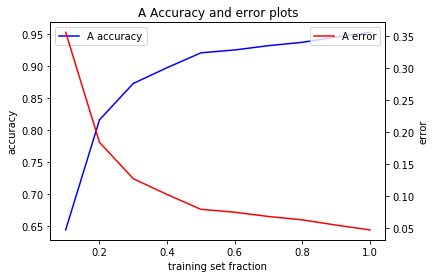

In [698]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
accuracy_plot = []
error_plot = []

accuracy_plot, error_plot = loop_discriminative_runs('A.csv', 'labels-A.csv')
print('accuracy plot list length ' + str(len(accuracy_plot)))
print('error plot list length ' + str(len(error_plot)))

ax1.plot(fractions, accuracy_plot, label='A accuracy', color='b')
ax1.set_xlabel('training set fraction')
ax1.set_ylabel('accuracy')
ax1.legend(loc='best')
ax1.set_title('A Accuracy and error plots')

ax2.plot(fractions, error_plot, label= 'A error', color='r')
ax2.set_xlabel('training set fraction')
ax2.set_ylabel('error')
ax2.legend(loc='best')

RUN loop_discriminative_runs() function again before running this..

(200,)
(200, 10)
(200, 11)
test set..
(66, 11)
(66,)
train set..
(134, 11)
(134,)
trainset shape(133, 11)
train label shape(133, 1)
testset shape(66, 11)
test label shape(66, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.924242424242
error is 0.0757575757576
trainset shape(134, 11)
train label shape(134, 1)
testset shape(66, 11)
test label shape(66, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.924242

/Users/sahiltyagi/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars


iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.924242424242
error is 0.0757575757576
trainset shape(134, 11)
train label shape(134, 1)
testset shape(66, 11)
test label shape(66, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.924242424242
error is 0.0757575757576
trainset shape(134, 11)
train label shape(134, 1)
testset shape(66, 11)
test label shape(66, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11


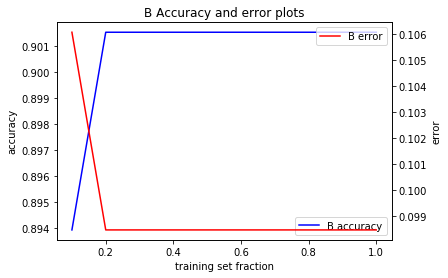

In [711]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
accuracy_plot = []
error_plot = []

accuracy_plot, error_plot = loop_discriminative_runs('B.csv', 'labels-B.csv')
print('accuracy plot list length ' + str(len(accuracy_plot)))
print('error plot list length ' + str(len(error_plot)))

ax1.plot(fractions, accuracy_plot, label='B accuracy', color='b')
ax1.set_xlabel('training set fraction')
ax1.set_ylabel('accuracy')
ax1.legend(loc='best')
ax1.set_title('B Accuracy and error plots')

ax2.plot(fractions, error_plot, label= 'B error', color='r')
ax2.set_xlabel('training set fraction')
ax2.set_ylabel('error')
ax2.legend(loc='best')

RUN loop_discriminative_runs() function again before running this..

(1540,)
(1540, 256)
(1540, 257)
test set..
(513, 257)
(513,)
train set..
(1027, 257)
(1027,)
trainset shape(133, 257)
train label shape(133, 1)
testset shape(513, 257)
test label shape(513, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11


/Users/sahiltyagi/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars


iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.949317738791
error is 0.0506822612086
trainset shape(266, 257)
train label shape(266, 1)
testset shape(513, 257)
test label shape(513, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.953216374269
error is 0.046783625731
trainset shape(400, 257)
train label shape(400, 1)
testset shape(513, 257)
test label shape(513, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iter

iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.949317738791
error is 0.0506822612086
trainset shape(1027, 257)
train label shape(1027, 1)
testset shape(513, 257)
test label shape(513, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
accuracy is 0.949317738791
error is 0.0506822612086
trainset shape(1027, 257)
train label shape(1027, 1)
testset shape(513, 257)
test label shape(513, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10

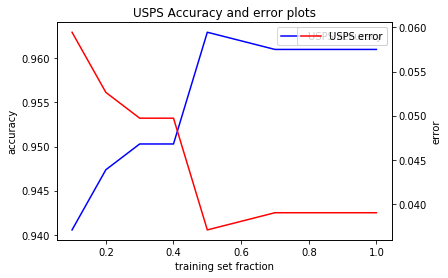

In [707]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
accuracy_plot = []
error_plot = []

accuracy_plot, error_plot = loop_discriminative_runs('usps.csv', 'labels-usps.csv')
print('accuracy plot list length ' + str(len(accuracy_plot)))
print('error plot list length ' + str(len(error_plot)))

ax1.plot(fractions, accuracy_plot, label='USPS accuracy', color='b')
ax1.set_xlabel('training set fraction')
ax1.set_ylabel('accuracy')
ax1.legend(loc='best')
ax1.set_title('USPS Accuracy and error plots')

ax2.plot(fractions, error_plot, label= 'USPS error', color='r')
ax2.set_xlabel('training set fraction')
ax2.set_ylabel('error')
ax2.legend(loc='best')

As the training set size increases from 10% to 100%, the accuracy increases and the error decreases. This is 
because the weight vectors get updated on a larger training set size and learn more to make better predictions on
the test dataset. This pattern occured on all three datasets: A, B and USPS. The accuracy was comparatively lower
on dataset B for both algorithms due to smaller training set size.

TASK 2: Newton's method vs Gradient Ascent

NEWTON'S METHOD

In [727]:
import numpy as np
import os

def no_randomness_read_input_file_with_added_feature(feature_file, label_file):
    input_feature = np.loadtxt(open("/Users/sahiltyagi/Downloads/pp3data/" + feature_file, "rb"), delimiter=",")
    input_label = np.loadtxt(open("/Users/sahiltyagi/Downloads/pp3data/" + label_file, "rb"), delimiter=",")
    print(input_label.shape)
    print(input_feature.shape)
    
    #added a vector column of 1
    input_feature = np.append(input_feature, np.ones([len(input_feature),1]), axis=1)
    print(input_feature.shape)
    
    test_set_size = int(input_feature.shape[0]/3)
    train_set_size = int(input_feature.shape[0] - test_set_size)
    ctr = 0
    test_set_indices = []
    
    ix = 0
    while len(test_set_indices) < test_set_size:
        if ix not in test_set_indices:
            test_set_indices.append(ix)
        ix = ix + 1
    #print('len test_set_indices ' + str(len(test_set_indices)))
        
    all_indices = []
    for i in range(0, input_feature.shape[0]):
        all_indices.append(i)
    #print('len all indices ' + str(len(all_indices)))
        
    train_set_indices = []
    for ix in all_indices:
        if ix not in test_set_indices:
            train_set_indices.append(ix)
    #print('len train_set_indices ' + str(len(train_set_indices)))
        
    testset_features = np.take(input_feature, test_set_indices, axis=0)
    testset_label = np.take(input_label, test_set_indices, axis=0)
    print('test set..')
    print(testset_features.shape)
    print(testset_label.shape)
    
    trainset_features = np.take(input_feature, train_set_indices, axis=0)
    trainset_label = np.take(input_label, train_set_indices, axis=0)
    print('train set..')
    print(trainset_features.shape)
    print(trainset_label.shape)
    
    return trainset_features, trainset_label, testset_features, testset_label

In [737]:
import math
from numpy import exp
import time

def newtons_method(trainset_features, trainset_label, testset_features, testset_label):
    
    w_vector_list = []
    runtime_list = []
    
    w = np.zeros([trainset_features.shape[1],1])
    #print(w.shape)
    alpha = 0.1
    w_n_norm = np.linalg.norm(w)
    stop_criteria = 10.0
    iterations = 0
    trainset_label = trainset_label.reshape((trainset_label.shape[0],1))
    print('trainset shape' + str(trainset_features.shape))
    print('train label shape' + str(trainset_label.shape))
    print('testset shape' + str(testset_features.shape))
    print('test label shape' + str(testset_label.shape))
    
    start_time = time.time()
    while iterations < 120:
        a_list = []
        
        for ix in range(0, trainset_features.shape[0]):
            record = trainset_features[ix,:]
            record = record.reshape([1,trainset_features.shape[1]])
            #print('record shape ' + str(record.shape))
            mew_a = np.matmul(record, w)
            #print('mew_a shape ' + str(mew_a.shape))
            S_n = alpha * np.identity(trainset_features.shape[1])
            #print('S_n shape ' + str(S_n.shape))
            sigma_a2 = np.matmul(record, np.matmul(S_n, np.transpose(record)))
            #print('sigma_a2 shape ' + str(sigma_a2.shape))
            
            a = float(mew_a) / float((math.sqrt(1 + (math.pi*sigma_a2)/8)))
            #print(a)
            
            a_list.append(a)
            
        a_val = np.array(a_list)
        #print(a_val.shape)
        
        
        y_1 = 1 / (1 + exp(-a_val))
        #print('y_1 vector is...')
        #print(y_1)
        #print('y1 shape is ' + str(y_1.shape))
        y_0 = 1 - y_1
        #print('y0 shape is ' + str(y_0.shape))
        
        y_1 = y_1.reshape((y_1.shape[0],1))
        y_0 = y_0.reshape((y_0.shape[0],1))
        
        Rmat = np.matmul(y_1, np.transpose(y_0))
        Rmat = np.diag(Rmat)
        #print('R matrix shape ' + str(Rmat.shape))
        identity_mat = np.identity(Rmat.shape[0])
        Rmat = np.multiply(Rmat, identity_mat)
        #print('R matrix diagonalized shape ' + str(Rmat.shape))
        #print(Rmat)
        
        alpha_I = alpha * np.identity(trainset_features.shape[1])
        #print('alpha_I ' + str(alpha_I.shape))
        Hessian = alpha_I + np.matmul(np.transpose(trainset_features), np.matmul(Rmat, trainset_features))
        Hessian_inverse = np.linalg.inv(Hessian)
        #print('Hessian_inv shape ' + str(Hessian_inverse.shape))
        #print('w shape again ' + str(w.shape))
        g = np.matmul(np.transpose(trainset_features), y_1 - trainset_label) + alpha*w
        #print('g shape is ' + str(g.shape))
        w = w - np.matmul(Hessian_inverse, g)
        #print(w.shape)
        end_time = time.time()
        
        w_vector_list.append(w)
        runtime_list.append(float(end_time - start_time))
        
        w_n_plus_1_norm = np.linalg.norm(w)
        # evaluate stop criterion here...
        
        stop_criteria = abs(w_n_plus_1_norm - w_n_norm)/w_n_norm
        #print('stop criterion threshold value is ' + str(stop_criteria))
        if stop_criteria < 0.001:
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............')
            break
        
        w_n_norm = np.linalg.norm(w)
        iterations = iterations + 1
        print('iteration ' + str(iterations))
        
    #print(w)
    # evaluating on the test set now...
    print('w_vector_list length is ' + str(len(w_vector_list)))
    #print(w_vector_list)
    error_across_updates = []
    for w_val in w_vector_list:
        testset_a = []
        for ix in range(0, testset_features.shape[0]):
            record = testset_features[ix,:]
            record = record.reshape([1,testset_features.shape[1]])
            #print('record shape ' + str(record.shape))
            mew_a = np.matmul(record, w_val)
            #print('mew_a shape ' + str(mew_a.shape))
            S_n = alpha * np.identity(testset_features.shape[1])
            #print('S_n shape ' + str(S_n.shape))
            sigma_a2 = np.matmul(record, np.matmul(S_n, np.transpose(record)))
            #print('sigma_a2 shape ' + str(sigma_a2.shape))
            
            a = float(mew_a) / float((math.sqrt(1 + (math.pi*sigma_a2)/8)))
            #print(a)
            testset_a.append(a)
            
        testset_a = np.array(testset_a)
        _, error = calculate_accuracy_and_error(testset_a, testset_label)
        error_across_updates.append(error)
        
    return error_across_updates, runtime_list
        

In [741]:
import time
import matplotlib.pyplot as plt

def run_newtons_method(feature_file, label_file, dataset):
    trainset_features, trainset_label, testset_features, testset_label = no_randomness_read_input_file_with_added_feature(feature_file, label_file)
    testset_label = testset_label.reshape((testset_label.shape[0],1))
    
    repeats = 3
    for i in range(0, repeats):
        error_across_updates, runtime_list = newtons_method(
            trainset_features, trainset_label, testset_features, testset_label)
        print('error_across_updates length ' + str(len(error_across_updates)))
        print('runtime_list length ' + str(len(runtime_list)))
        
    plt.plot(runtime_list, error_across_updates)
    plt.xlabel('run time (sec)')
    plt.ylabel('Test error')
    plt.title('Dataset ' + dataset)
    plt.show()

(2000,)
(2000, 60)
(2000, 61)
test set..
(666, 61)
(666,)
train set..
(1334, 61)
(1334,)
trainset shape(1334, 61)
train label shape(1334, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4


/Users/sahiltyagi/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in double_scalars


iteration 5
iteration 6
iteration 7
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
w_vector_list length is 8
accuracy is 0.941441441441
error is 0.0585585585586
accuracy is 0.947447447447
error is 0.0525525525526
accuracy is 0.948948948949
error is 0.0510510510511
accuracy is 0.948948948949
error is 0.0510510510511
accuracy is 0.947447447447
error is 0.0525525525526
accuracy is 0.948948948949
error is 0.0510510510511
accuracy is 0.948948948949
error is 0.0510510510511
accuracy is 0.948948948949
error is 0.0510510510511
error_across_updates length 8
runtime_list length 8
trainset shape(1334, 61)
train label shape(1334, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
w_vector_list length is 8
accuracy is 0.941441441441
error is 0.0585585585586
accuracy is 0.947447447447
err

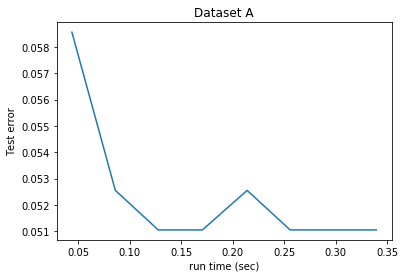

In [742]:
run_newtons_method('A.csv', 'labels-A.csv', 'A')

(1540,)
(1540, 256)
(1540, 257)
test set..
(513, 257)
(513,)
train set..
(1027, 257)
(1027,)
trainset shape(1027, 257)
train label shape(1027, 1)
testset shape(513, 257)
test label shape(513, 1)
iteration 1


/Users/sahiltyagi/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in double_scalars


iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
w_vector_list length is 22
accuracy is 0.959064327485
error is 0.0409356725146
accuracy is 0.961013645224
error is 0.0389863547758
accuracy is 0.961013645224
error is 0.0389863547758
accuracy is 0.962962962963
error is 0.037037037037
accuracy is 0.961013645224
error is 0.0389863547758
accuracy is 0.964912280702
error is 0.0350877192982
accuracy is 0.966861598441
error is 0.0331384015595
accuracy is 0.970760233918
error is 0.0292397660819
accuracy is 0.972709551657
error is 0.0272904483431
accuracy is 0.970760233918
error is 0.0292397660819
accuracy is 0.968810916179
error is 0.0311890838207
accuracy is 0.970760233918
error is 0.0292397660819
accuracy 

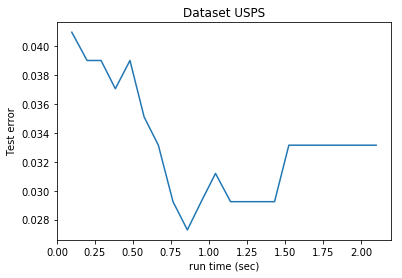

In [743]:
run_newtons_method('usps.csv', 'labels-usps.csv', 'USPS')

GRADIENT ASCENT

In [760]:
import math
from numpy import exp
import time

def gradient_ascent(trainset_features, trainset_label, testset_features, testset_label, iter_threshold):
    
    learning_rate = 0.001
    
    w_vector_list = []
    runtime_list = []
    
    w = np.zeros([trainset_features.shape[1],1])
    #print(w.shape)
    alpha = 0.1
    w_n_norm = np.linalg.norm(w)
    stop_criteria = 10.0
    iterations = 0
    trainset_label = trainset_label.reshape((trainset_label.shape[0],1))
    print('trainset shape' + str(trainset_features.shape))
    print('train label shape' + str(trainset_label.shape))
    print('testset shape' + str(testset_features.shape))
    print('test label shape' + str(testset_label.shape))
    
    start_time = time.time()
    while iterations < iter_threshold:
        a_list = []
        
        for ix in range(0, trainset_features.shape[0]):
            record = trainset_features[ix,:]
            record = record.reshape([1,trainset_features.shape[1]])
            #print('record shape ' + str(record.shape))
            mew_a = np.matmul(record, w)
            #print('mew_a shape ' + str(mew_a.shape))
            S_n = alpha * np.identity(trainset_features.shape[1])
            #print('S_n shape ' + str(S_n.shape))
            sigma_a2 = np.matmul(record, np.matmul(S_n, np.transpose(record)))
            #print('sigma_a2 shape ' + str(sigma_a2.shape))
            
            a = float(mew_a) / float((math.sqrt(1 + (math.pi*sigma_a2)/8)))
            #print(a)
            
            a_list.append(a)
            
        a_val = np.array(a_list)
        #print(a_val.shape)
        
        
        y_1 = 1 / (1 + exp(-a_val))
        #print('y_1 vector is...')
        #print(y_1)
        #print('y1 shape is ' + str(y_1.shape))
        y_0 = 1 - y_1
        #print('y0 shape is ' + str(y_0.shape))
        
        y_1 = y_1.reshape((y_1.shape[0],1))
        y_0 = y_0.reshape((y_0.shape[0],1))
        
        
        g = np.matmul(np.transpose(trainset_features), y_1 - trainset_label) + alpha*w
        #print('g shape is ' + str(g.shape))
        w = w - learning_rate * g
        #print(w.shape)
        end_time = time.time()
        
        if iterations % 1 == 0:
            w_vector_list.append(w)
            runtime_list.append(float(end_time - start_time))
        
        w_n_plus_1_norm = np.linalg.norm(w)
        # evaluate stop criterion here...
        
        stop_criteria = abs(w_n_plus_1_norm - w_n_norm)/w_n_norm
        #print('stop criterion threshold value is ' + str(stop_criteria))
        if stop_criteria < 0.001:
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............')
            break
        
        w_n_norm = np.linalg.norm(w)
        iterations = iterations + 1
        print('iteration ' + str(iterations))
        
    #print(w)
    # evaluating on the test set now...
    print('w_vector_list length is ' + str(len(w_vector_list)))
    #print(w_vector_list)
    error_across_updates = []
    for w_val in w_vector_list:
        testset_a = []
        for ix in range(0, testset_features.shape[0]):
            record = testset_features[ix,:]
            record = record.reshape([1,testset_features.shape[1]])
            #print('record shape ' + str(record.shape))
            mew_a = np.matmul(record, w_val)
            #print('mew_a shape ' + str(mew_a.shape))
            S_n = alpha * np.identity(testset_features.shape[1])
            #print('S_n shape ' + str(S_n.shape))
            sigma_a2 = np.matmul(record, np.matmul(S_n, np.transpose(record)))
            #print('sigma_a2 shape ' + str(sigma_a2.shape))
            
            a = float(mew_a) / float((math.sqrt(1 + (math.pi*sigma_a2)/8)))
            #print(a)
            testset_a.append(a)
            
        testset_a = np.array(testset_a)
        _, error = calculate_accuracy_and_error(testset_a, testset_label)
        error_across_updates.append(error)
        
    return error_across_updates, runtime_list

In [761]:
import time
import matplotlib.pyplot as plt

def run_gradient_ascent(feature_file, label_file, dataset):
    trainset_features, trainset_label, testset_features, testset_label = no_randomness_read_input_file_with_added_feature(feature_file, label_file)
    testset_label = testset_label.reshape((testset_label.shape[0],1))
    
    iterations = 6000
    repeats = 3
    for i in range(0, repeats):
        error_across_updates, runtime_list = gradient_ascent(
            trainset_features, trainset_label, testset_features, testset_label, iterations)
        print('error_across_updates length ' + str(len(error_across_updates)))
        print('runtime_list length ' + str(len(runtime_list)))
        
    plt.plot(runtime_list, error_across_updates)
    plt.xlabel('run time (sec)')
    plt.ylabel('Test error')
    plt.title('Dataset ' + dataset)
    plt.show()

(2000,)
(2000, 60)
(2000, 61)
test set..
(666, 61)
(666,)
train set..
(1334, 61)
(1334,)
trainset shape(1334, 61)
train label shape(1334, 1)
testset shape(666, 61)
test label shape(666, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6


/Users/sahiltyagi/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
w_vector_list length is 54
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.5165165

accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
error is 0.516516516517
accuracy is 0.516516516517
error is 0.483483483483
accuracy is 0.483483483483
erro

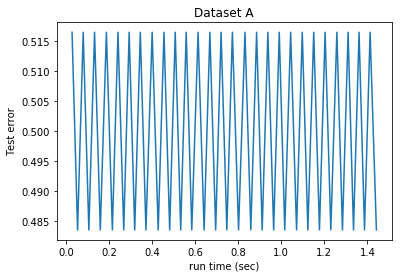

In [762]:
run_gradient_ascent('A.csv', 'labels-A.csv', 'A')

(1540,)
(1540, 256)
(1540, 257)
test set..
(513, 257)
(513,)
train set..
(1027, 257)
(1027,)
trainset shape(1027, 257)
train label shape(1027, 1)
testset shape(513, 257)
test label shape(513, 1)
iteration 1
iteration 2


/Users/sahiltyagi/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! reached threshold...............
w_vector_list length is 10
accuracy is 0.604288499025
error is 0.395711500975
accuracy is 0.463937621832
error is 0.536062378168
accuracy is 0.539961013645
error is 0.460038986355
accuracy is 0.666666666667
error is 0.333333333333
accuracy is 0.600389863548
error is 0.399610136452
accuracy is 0.615984405458
error is 0.384015594542
accuracy is 0.664717348928
error is 0.335282651072
accuracy is 0.834307992203
error is 0.165692007797
accuracy is 0.894736842105
error is 0.105263157895
accuracy is 0.947368421053
error is 0.0526315789474
error_across_updates length 10
runtime_list length 10
trainset shape(1027, 257)
train label shape(1027, 1)
testset shape(513, 257)
test label shape(513, 1)
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
!!!!!!!!!!!!!!!!!!!!!!!!!

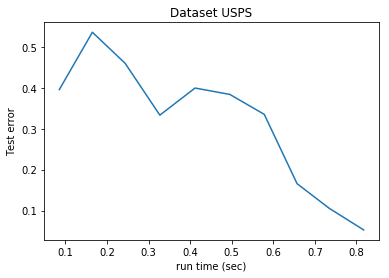

In [763]:
run_gradient_ascent('usps.csv', 'labels-usps.csv', 'USPS')

Newton's method is computationally more demanding than Gradient Ascent. To reach the same number of iterations on USPS data, gradient ascent took 0.8 seconds while newton's method took 2 seconds. For dataset A, gradient ascent took 0.2 seconds (after logging every 10 iterations) while newton's method took about 0.35 seconds. However, it is worth pointing out that NEWTON'S METHOD ACHIEVED FAR BETTER TEST ACCURACY THAN GRADIENT ASCENT FOR A FIXED NUMBER OF ITERATIONS. This is because the Hessian inverse gives a far better estimate of the direction to take than an arbitrarily set fixed step-size/learning-rate.

EXTRA CREDIT: Line search and its effect on convergence and speed of gradient ascent

Line search is used to approximate the CLOSE-TO-IDEAL value of the stepsize (or learning rate) when calculating the Hessian is computationally expensive or unfeasible. The analogy between the stepsize value and the Hessian (or more precisely the inverse of the Hessian) can be seen from the update equations of Newton's method and gradient ascent.

To implement line search with gradient ascent, I implement and evaluate BACKTRACKING LINE SEARCH, where we specify two parameters, alpha (between 0 and 0.5) and beta (between 0 and 1). The step size is updated at every iteration as new_step_size = (beta * old_step_size) until the backtracking line search condition for step-size adjustment is satisfied.

I start with an initial step-size of 1, an alpha of 0.3 and a beta of 0.8 for the simple quadratic equation (x^2 -5x + 6). Since its a quadratic function, its STRONGLY CONVEX and the solution for this equation are x=2,3. We do a line search on the step-size for this quadratic function.

WE COMPARE BELOW THE TWO STRATEGIES: 
1.) GRADIENT ASCENT WITH LINE SEARCH TO FIND THE OPTIMUM STEP-SIZE 

2.) GRADIENT ASCENT WITH CONSTANT STEP-SIZE

We draw the plots for loss, correspondign step-size values and X variable value with the two approaches.

In [89]:
def calc_grad(x):
    val = (2*x) - 5
    return val

In [93]:
import math
def loss_val(x):
    x = float(x)
    val1 = math.square(x) 
    val2 = (-5)*x 
    val3 = 6
    val = val1 + val2 + val3
    return val

In [136]:
import math
import matplotlib.pyplot as plt

def backtrackingg_line_search():
    step_size = 1.0
    alpha = 0.3
    beta = 0.8
    
    iterations = 0
    max_iterations = 100
    loss_val = 100.0
    loss_threshold = 0.001
    
    x = 10.0
    loss_list = []
    stepsize_list = []
    x_list = []
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    while iterations < max_iterations or loss_val < loss_threshold:

        loss_1 = x*x - 5*x + 6
        #print('loss is ' + str(loss_1))
        loss_list.append(loss_1)
        stepsize_list.append(step_size)
        x_list.append(x)
        
        grad = 2*x - 5
        new_x = x - step_size * grad
        
        new_loss = new_x*new_x - 5*new_x + 6
        #print('')
        
        if new_loss > (loss_1 - alpha * step_size * np.linalg.norm(calc_grad(x))):
            step_size = beta * step_size
            print('updated step size is ' + str(step_size))
        
        x = new_x
        iterations = iterations + 1

    ax1.plot(loss_list, stepsize_list, color = 'b', label='Step size')
    ax1.set_ylabel('Step size')
    ax1.set_xlabel('Loss value')
    ax1.legend(loc='upper left')
    
    ax2.plot(loss_list, x_list, color = 'r', label='X variable')
    ax2.set_ylabel('X variable val')
    ax2.legend(loc='upper right')
    

updated step size is 0.8
updated step size is 0.64
updated step size is 0.512
updated step size is 0.4096
updated step size is 0.32768
updated step size is 0.262144
updated step size is 0.2097152
updated step size is 0.16777216
updated step size is 0.134217728
updated step size is 0.1073741824
updated step size is 0.08589934592
updated step size is 0.068719476736
updated step size is 0.0549755813888
updated step size is 0.043980465111
updated step size is 0.0351843720888
updated step size is 0.0281474976711
updated step size is 0.0225179981369
updated step size is 0.0180143985095
updated step size is 0.0144115188076
updated step size is 0.0115292150461
updated step size is 0.00922337203685
updated step size is 0.00737869762948
updated step size is 0.00590295810359
updated step size is 0.00472236648287
updated step size is 0.0037778931863
updated step size is 0.00302231454904
updated step size is 0.00241785163923
updated step size is 0.00193428131138
updated step size is 0.0015474250491

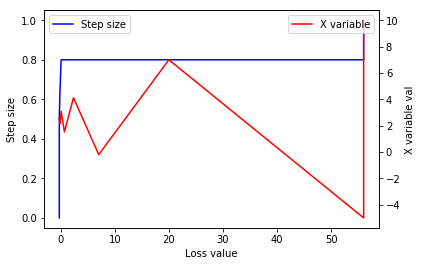

In [137]:
backtrackingg_line_search()

In [132]:
import math
import matplotlib.pyplot as plt

def NO_backtrackingg_line_search():
    step_size = 0.6
    alpha = 0.3
    beta = 0.8
    
    iterations = 0
    max_iterations = 100
    loss_val = 100.0
    loss_threshold = 0.001
    
    x = 20.0
    loss_list = []
    stepsize_list = []
    x_list = []
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    while iterations < max_iterations or loss_val < loss_threshold:

        loss_1 = x*x - 5*x + 6
        #print('loss is ' + str(loss_1))
        loss_list.append(loss_1)
        stepsize_list.append(step_size)
        x_list.append(x)
        
        grad = 2*x - 5
        new_x = x - step_size * grad
        
        new_loss = new_x*new_x - 5*new_x + 6
        
        x = new_x
        iterations = iterations + 1

    ax1.plot(loss_list, stepsize_list, color = 'b', label='Step size')
    ax1.set_ylabel('Step size')
    ax1.set_xlabel('Loss value')
    ax1.legend(loc='upper left')
    
    ax2.plot(loss_list, x_list, color = 'r', label='X variable')
    ax2.set_ylabel('X variable val')
    ax2.legend(loc='upper right')
    

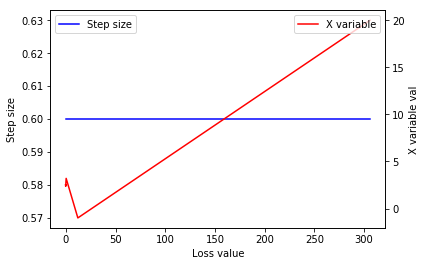

In [133]:
NO_backtrackingg_line_search()